# Vehicle Recall Data - David's Work with CMPL and Mileage
### Initial Questions
* What Make/Model is being recalled?
    * See Fig 1, Fig 2, and Fig 3
    * Honda, Ford, Blue Bird most common
* What specific problems led to the recall?
    * Most common by far is airbags (Fig 5)
* Is this correlated to an increase in defects or better QA?
* At what mileage did we start seeing the problem?
    * Average Miles at Failure: 68334.08213141191
* Did an increase in complaints lead to a recall?
    * Generally, as the number of recalls go up, the number of complaints also go up (Fig 4)

In [1]:
import pandas as pd
import re

data_path = 'data'
fields_path = 'fields'

# Read and parse a file containing column names for a dataset.
# Returns a list of strings (the column names).
def load_column_names(columns_file_name):
    file = open(columns_file_name)
    column_names = []
    readingFields = False
    for line in file:
        if readingFields:
            if re.match('^[0-9]', line):
                split_line = line.split()
                column_names.append(split_line[1])
        elif line.startswith('Field#'):
            readingFields = True
    file.close()
    return column_names
#}

# Load a dataest by its abbreviated names (ex: RCL).
def load_data_file(name, encoding):
    
    # Read the column names from a separate file.
    fields_file_name = fields_path + '/' + name + '.txt';
    names = load_column_names(fields_file_name)
    
    # Read the data from a CSV file.
    data_file_name = 'FLAT_' + name + '.txt';
    df = pd.read_csv(data_path + '/' + data_file_name,
                     delimiter='\t', header=None, encoding=encoding, names=names)
    
    return df
#}

In [2]:
import codecs
import numpy as py
import matplotlib
import matplotlib.pyplot as plt

rcl_df = load_data_file('RCL', encoding='latin1')
rcl_df

C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,RECORD_ID,CAMPNO,MAKETXT,MODELTXT,YEARTXT,MFGCAMPNO,COMPNAME,MFGNAME,BGMAN,ENDMAN,...,MFGTXT,RCDATE,DATEA,RPNO,FMVSS,DESC_DEFECT,CONEQUENCE_DEFECT,CORRECTIVE_ACTION,NOTES,RCL_CMPT_ID
0,1,02V288000,FORD,FOCUS,2001,02S41,ELECTRICAL SYSTEM:BATTERY:CABLES,FORD MOTOR COMPANY,19990719.0,20010531.0,...,Ford Motor Company,20021106.0,20021106,NaN,NaN,CERTAIN PASSENGER VEHICLES EQUIPPED WITH ZETEC...,"THIS, IN TURN, COULD CAUSE THE BATTERY CABLES ...",DEALERS WILL INSPECT THE BATTERY CABLES FOR TH...,ALSO CONTACT THE NATIONAL HIGHWAY TRAFFIC SAFE...,000015339000215022000000202
1,2,02V288000,FORD,FOCUS,2000,02S41,ELECTRICAL SYSTEM:BATTERY:CABLES,FORD MOTOR COMPANY,19990719.0,20010531.0,...,Ford Motor Company,20021106.0,20021106,NaN,NaN,CERTAIN PASSENGER VEHICLES EQUIPPED WITH ZETEC...,"THIS, IN TURN, COULD CAUSE THE BATTERY CABLES ...",DEALERS WILL INSPECT THE BATTERY CABLES FOR TH...,ALSO CONTACT THE NATIONAL HIGHWAY TRAFFIC SAFE...,000015339000215021000000202
2,3,02V236000,JAYCO,FT EAGLE 10 SG,2003,NaN,EQUIPMENT:OTHER:LABELS,"JAYCO, INC.",20020730.0,20020813.0,...,"Jayco, Inc.",20020904.0,20020912,NaN,NaN,"ON CERTAIN FOLDING TENT CAMPERS, THE FEDERAL C...","IF THE TIRES WERE INFLATED TO 80 PSI, THEY COU...",OWNERS WILL BE MAILED CORRECT LABELS FOR INSTA...,"ALSO, CUSTOMERS CAN CONTACT THE NATIONAL HIGHW...",000015210000106403000000349
3,4,02V237000,HOLIDAY RAMBLER,ADMIRAL SE,2003,NaN,STRUCTURE,MONACO COACH CORP.,NaN,NaN,...,MONACO COACH CORPORATION,20020909.0,20020912,NaN,NaN,"ON CERTAIN CLASS A MOTOR HOMES, THE FLOOR TRUS...",CONDITIONS CAN RESULT IN THE BOTTOMING OUT THE...,DEALERS WILL INSPECT THE FLOOR TRUSS NETWORK S...,CUSTOMERS CAN ALSO CONTACT THE NATIONAL HIGHWA...,000015211000106325000000272
4,5,02V237000,HOLIDAY RAMBLER,ADMIRAL SE,2002,NaN,STRUCTURE,MONACO COACH CORP.,NaN,NaN,...,MONACO COACH CORPORATION,20020909.0,20020912,NaN,NaN,"ON CERTAIN CLASS A MOTOR HOMES, THE FLOOR TRUS...",CONDITIONS CAN RESULT IN THE BOTTOMING OUT THE...,DEALERS WILL INSPECT THE FLOOR TRUSS NETWORK S...,CUSTOMERS CAN ALSO CONTACT THE NATIONAL HIGHWA...,000015211000106324000000272
5,6,02V237000,HOLIDAY RAMBLER,ADMIRAL,1999,NaN,STRUCTURE,MONACO COACH CORP.,NaN,NaN,...,MONACO COACH CORPORATION,20020909.0,20020912,NaN,NaN,"ON CERTAIN CLASS A MOTOR HOMES, THE FLOOR TRUS...",CONDITIONS CAN RESULT IN THE BOTTOMING OUT THE...,DEALERS WILL INSPECT THE FLOOR TRUSS NETWORK S...,CUSTOMERS CAN ALSO CONTACT THE NATIONAL HIGHWA...,000015211000106323000000272
6,7,02V237000,MONACO COACH,MONARCH SE,2003,NaN,STRUCTURE,MONACO COACH CORP.,NaN,NaN,...,MONACO COACH CORPORATION,20020909.0,20020912,NaN,NaN,"ON CERTAIN CLASS A MOTOR HOMES, THE FLOOR TRUS...",CONDITIONS CAN RESULT IN THE BOTTOMING OUT THE...,DEALERS WILL INSPECT THE FLOOR TRUSS NETWORK S...,CUSTOMERS CAN ALSO CONTACT THE NATIONAL HIGHWA...,000015211000106322000000272
7,8,02V237000,MONACO COACH,MONARCH SE,2002,NaN,STRUCTURE,MONACO COACH CORP.,NaN,NaN,...,MONACO COACH CORPORATION,20020909.0,20020912,NaN,NaN,"ON CERTAIN CLASS A MOTOR HOMES, THE FLOOR TRUS...",CONDITIONS CAN RESULT IN THE BOTTOMING OUT THE...,DEALERS WILL INSPECT THE FLOOR TRUSS NETWORK S...,CUSTOMERS CAN ALSO CONTACT THE NATIONAL HIGHWA...,000015211000106321000000272
8,9,02V237000,MONACO COACH,LAPALMA,1999,NaN,STRUCTURE,MONACO COACH CORP.,NaN,NaN,...,MONACO COACH CORPORATION,20020909.0,20020912,NaN,NaN,"ON CERTAIN CLASS A MOTOR HOMES, THE FLOOR TRUS...",CONDITIONS CAN RESULT IN THE BOTTOMING OUT THE...,DEALERS WILL INSPECT THE FLOOR TRUSS NETWORK S...,CUSTOMERS CAN ALSO CONTACT THE NATIONAL HIGHWA...,000015211000106320000000272
9,10,02V237000,MONACO COACH,LAPALMA,2003,NaN,STRUCTURE,MONACO COACH CORP.,NaN,NaN,...,MONACO COACH CORPORATION,20020909.0,20020912,NaN,NaN,"ON CERTAIN CLASS A MOTOR HOMES, THE FLOOR TRUS...",CONDITIONS CAN RESULT IN THE BOTTOMING OUT THE...,DEALERS WILL INSPECT THE FLOOR TRUSS NETWORK S...,CUSTOMERS CAN ALSO CONTACT THE NATIONAL HIGHWA...,000015211000105496000000272


/Users/matt/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


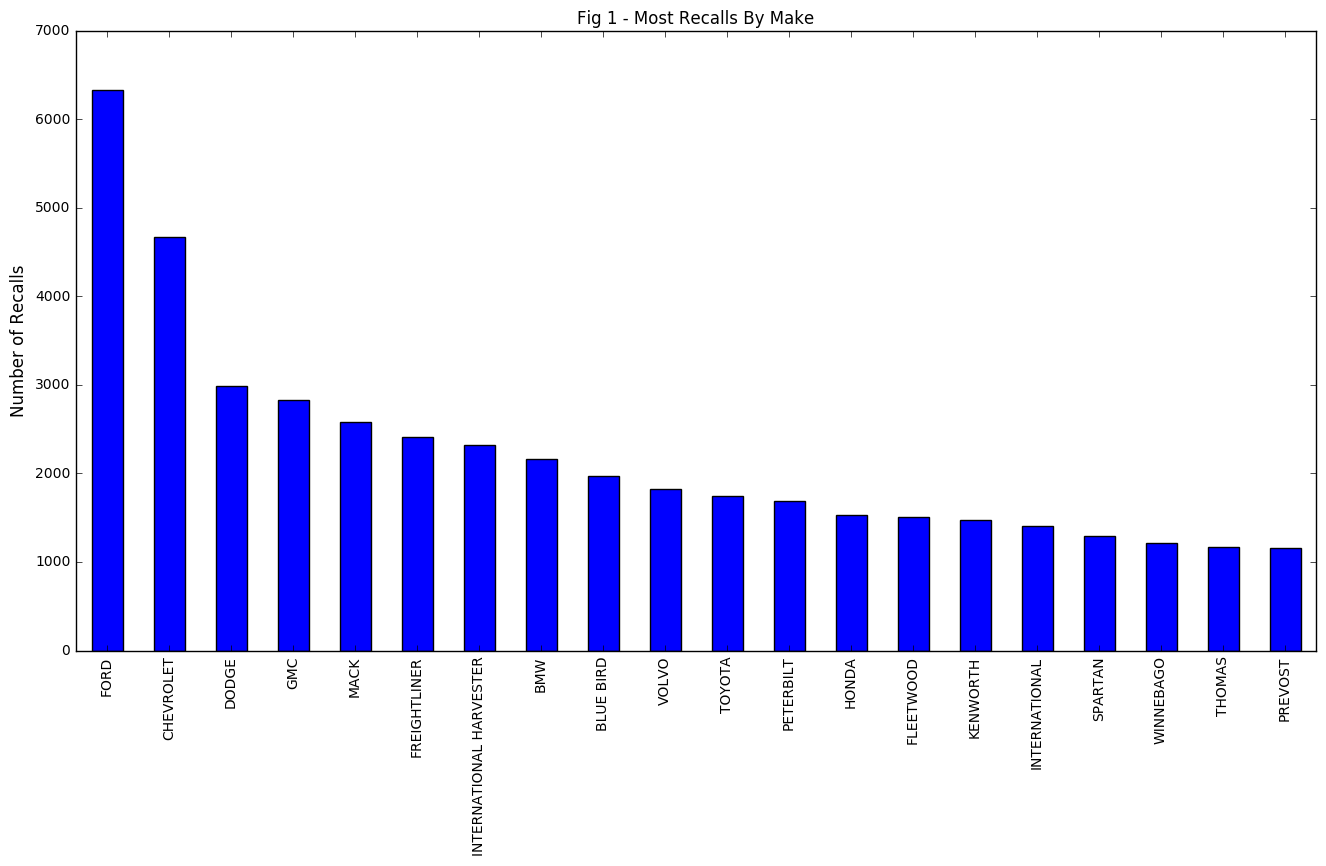

In [67]:
# Make Counts
plt.figure(figsize=(16,8))
rcl_df['MAKETXT'].value_counts().nlargest(20).plot(kind='bar')
plt.title("Fig 1 - Most Recalls By Make")
plt.ylabel('Number of Recalls', fontsize=12)
plt.gcf()

/Users/matt/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


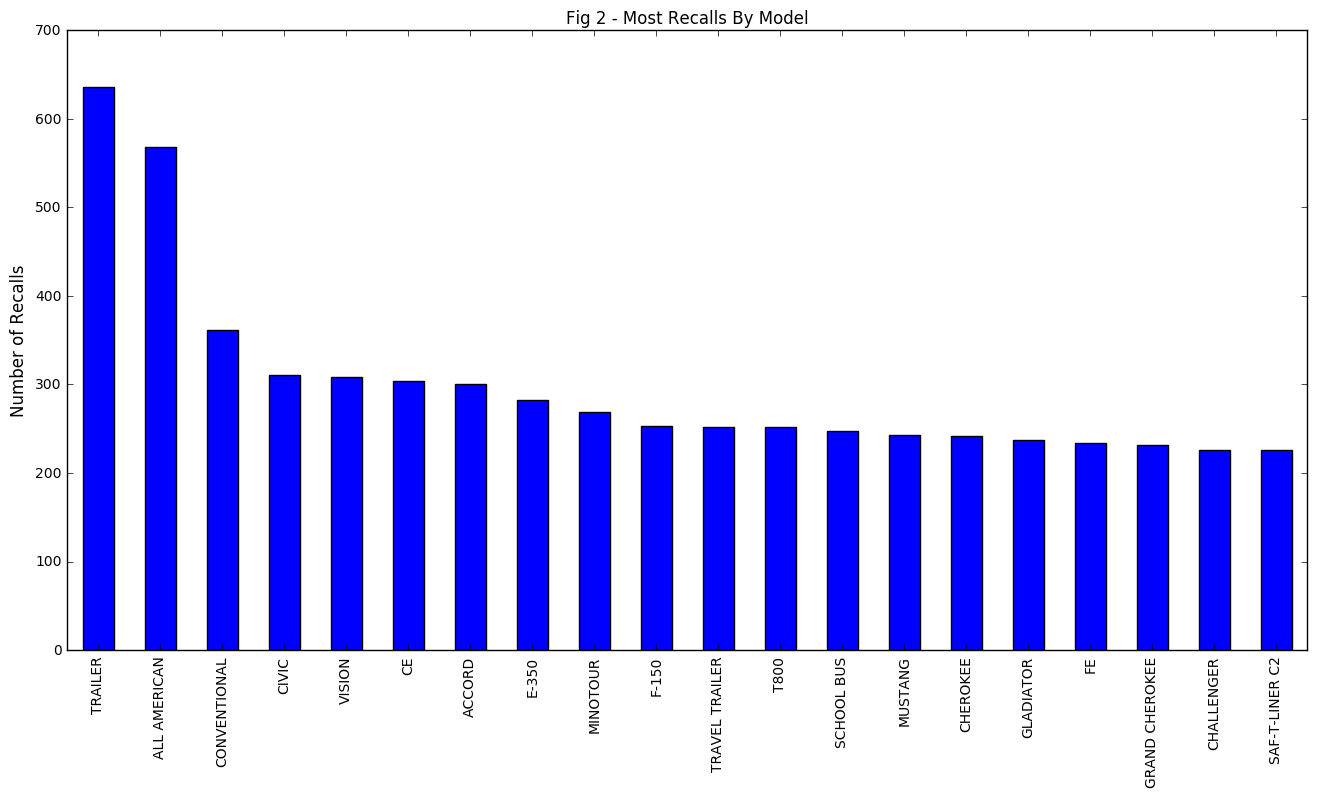

In [69]:
# Model Counts
plt.figure(figsize=(16,8))
df['MODELTXT'].value_counts().nlargest(20).plot(kind='bar')
plt.title("Fig 2 - Most Recalls By Model")
plt.ylabel('Number of Recalls', fontsize=12)
plt.gcf()

In [2]:
# Defect Counts
plt.figure(figsize=(16,8))
rcl_df2 = df[19].value_counts().nlargest(20)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             8199
CERTAIN HONEYWELL FRAM RACING BRAND HP4 AND HP8 OIL FILTERS THAT WERE MANUFACTURED FROM MAY 25, 2006, THROUGH SEPTEMBER 14, 2007, AND SOLD FOR USE AS REPLACEMENT EQUIPMENT FOR VEHICLES LIST ABOVE.  THE AFFECTED FILTERS ARE MARKED WITH A DATE CODE A61451 THROUGH A72571 SEQUENTIALLY.  THE DATE CODE AND PART NUMBER APPEAR ON THE FILTER HOUSING.  FRAM RACING H

/Users/matt/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


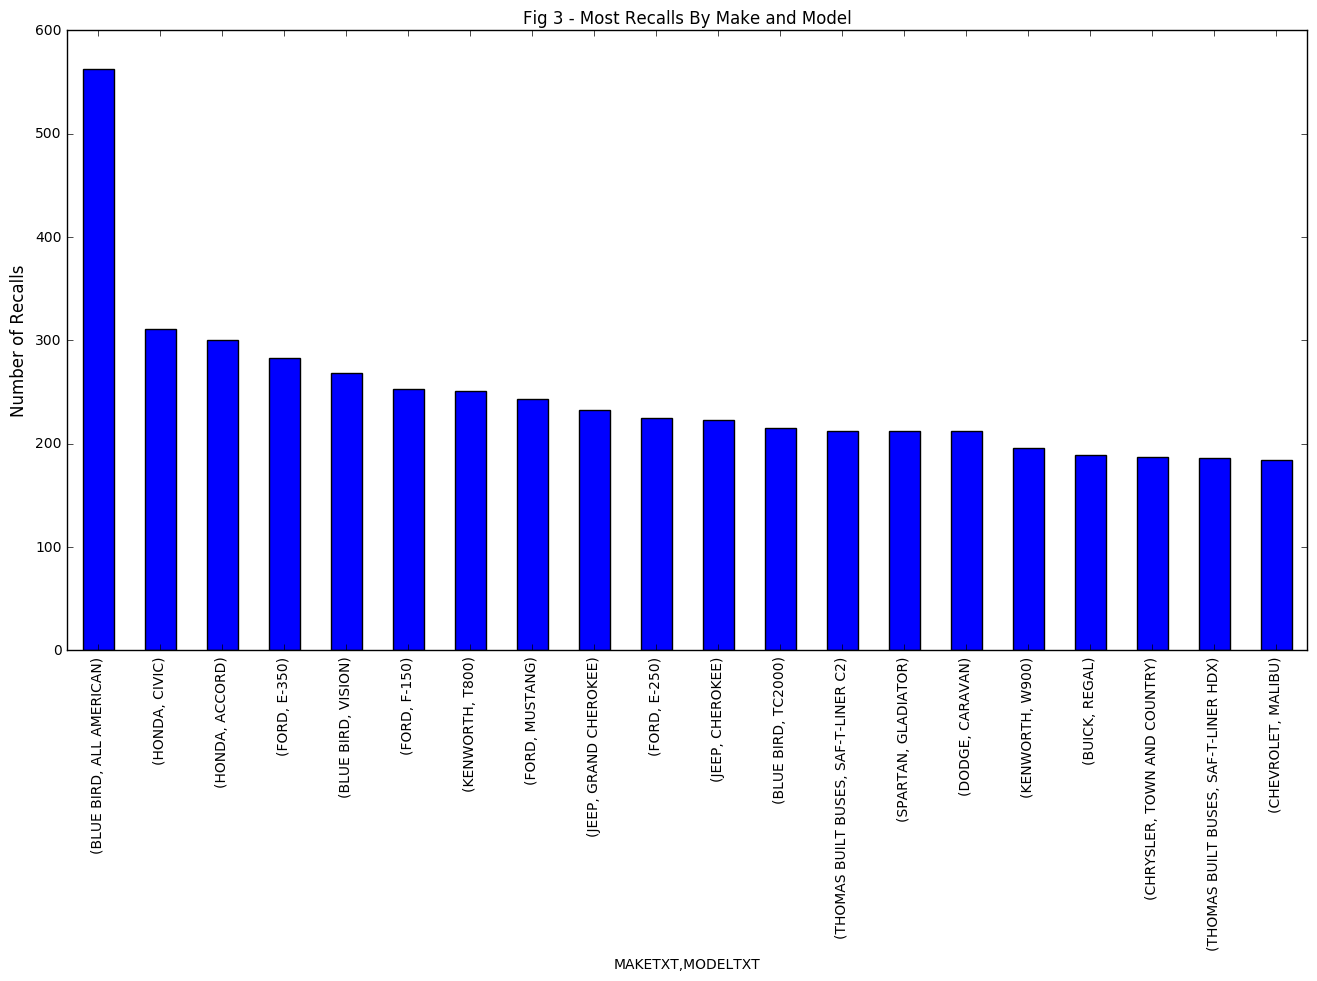

In [68]:
# Model Counts
plt.figure(figsize=(16,8))
rcl_df.groupby(['MAKETXT','MODELTXT']).size().sort_values(ascending=False).nlargest(20).plot(kind='bar')
plt.title("Fig 3 - Most Recalls By Make and Model")
plt.ylabel('Number of Recalls', fontsize=12)
plt.gcf()

In [127]:
cmpl_df = load_data_file('CMPL', encoding='iso-8859-1')

/Users/matt/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (15,22,26,32,33,34,35,36,38,39,40,41,42,43,44,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


/Users/matt/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


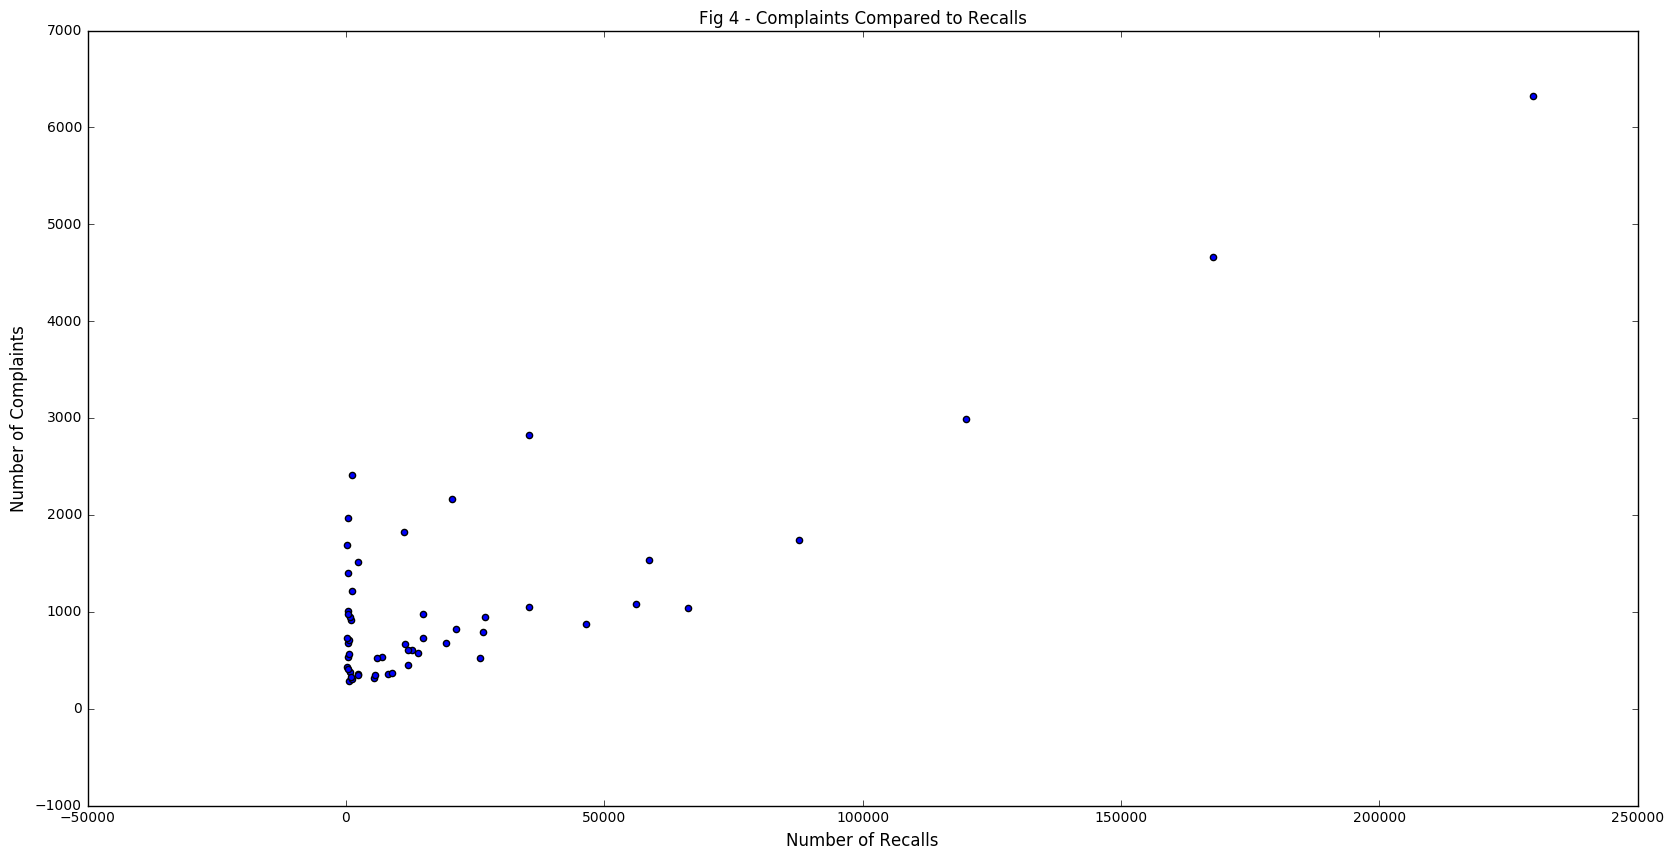

In [70]:
rcnt = rcl_df['MAKETXT'].value_counts().nlargest(100)
ccnt = cmpl_df['MAKETXT'].value_counts().nlargest(100)
cat = pd.concat([rcnt,ccnt],axis=1)
cat.columns = ['1','2']

plt.figure(figsize=(16,8))
cat.plot.scatter(x ='2',y='1')
plt.title("Fig 4 - Complaints Compared to Recalls")
plt.ylabel('Number of Complaints', fontsize=12)
plt.xlabel('Number of Recalls', fontsize=12)
plt.gcf()

In [83]:
inv_df = load_data_file('INV', encoding='iso-8859-1')
inv_df

,NHTSA,MAKE,MODEL,YEAR,COMPNAME,MFR_NAME,ODATE,CDATE,CAMPNO,SUBJECT,SUMMARY
0,C85007,BUICK,CENTURY,1982.0,"SERVICE BRAKES, HYDRAULIC",General Motors LLC,19850619.0,19890518.0,66V178000,REAR BRAKE LOCKUP,There is no summary currently available
1,C85007,BUICK,CENTURY,1984.0,"SERVICE BRAKES, HYDRAULIC",General Motors LLC,19850619.0,19890518.0,66V178000,REAR BRAKE LOCKUP,There is no summary currently available
2,C85007,CHEVROLET,CELEBRITY,1982.0,"SERVICE BRAKES, HYDRAULIC",General Motors LLC,19850619.0,19890518.0,66V178000,REAR BRAKE LOCKUP,There is no summary currently available
3,C85007,PONTIAC,6000,1985.0,"SERVICE BRAKES, HYDRAULIC",General Motors LLC,19850619.0,19890518.0,66V003000,REAR BRAKE LOCKUP,There is no summary currently available
4,C85007,PONTIAC,6000,1985.0,"SERVICE BRAKES, HYDRAULIC",General Motors LLC,19850619.0,19890518.0,66V178000,REAR BRAKE LOCKUP,There is no summary currently available
5,C86001,AUDI,5000,1980.0,VEHICLE SPEED CONTROL:LINKAGES,"Volkswagen Group of America, Inc.",19860805.0,19890711.0,NaN,SUDDEN ACCELERATION,There is no summary currently available
6,C87002,ARROWCRAFT,ARROWCRAFT,1978.0,SUSPENSION,ARROWCRAFT PRODUCTS,19870427.0,19910830.0,NaN,REAR AXLE FRACTURE,There is no summary currently available
7,C87003,FORD,E350,1984.0,VEHICLE SPEED CONTROL:LINKAGES,Ford Motor Company,19870429.0,19870901.0,NaN,FILLER NECK SPURT,There is no summary currently available
8,C88001,CHRYSLER,LASER,1985.0,SEATS,Chrysler (FCA US LLC),19880518.0,19891030.0,NaN,SEAT ATTACHMENT FAILURE,There is no summary currently available
9,C88001,CHRYSLER,LEBARON,1986.0,SEATS,Chrysler (FCA US LLC),19880518.0,19891030.0,NaN,SEAT ATTACHMENT FAILURE,There is no summary currently available


/Users/matt/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


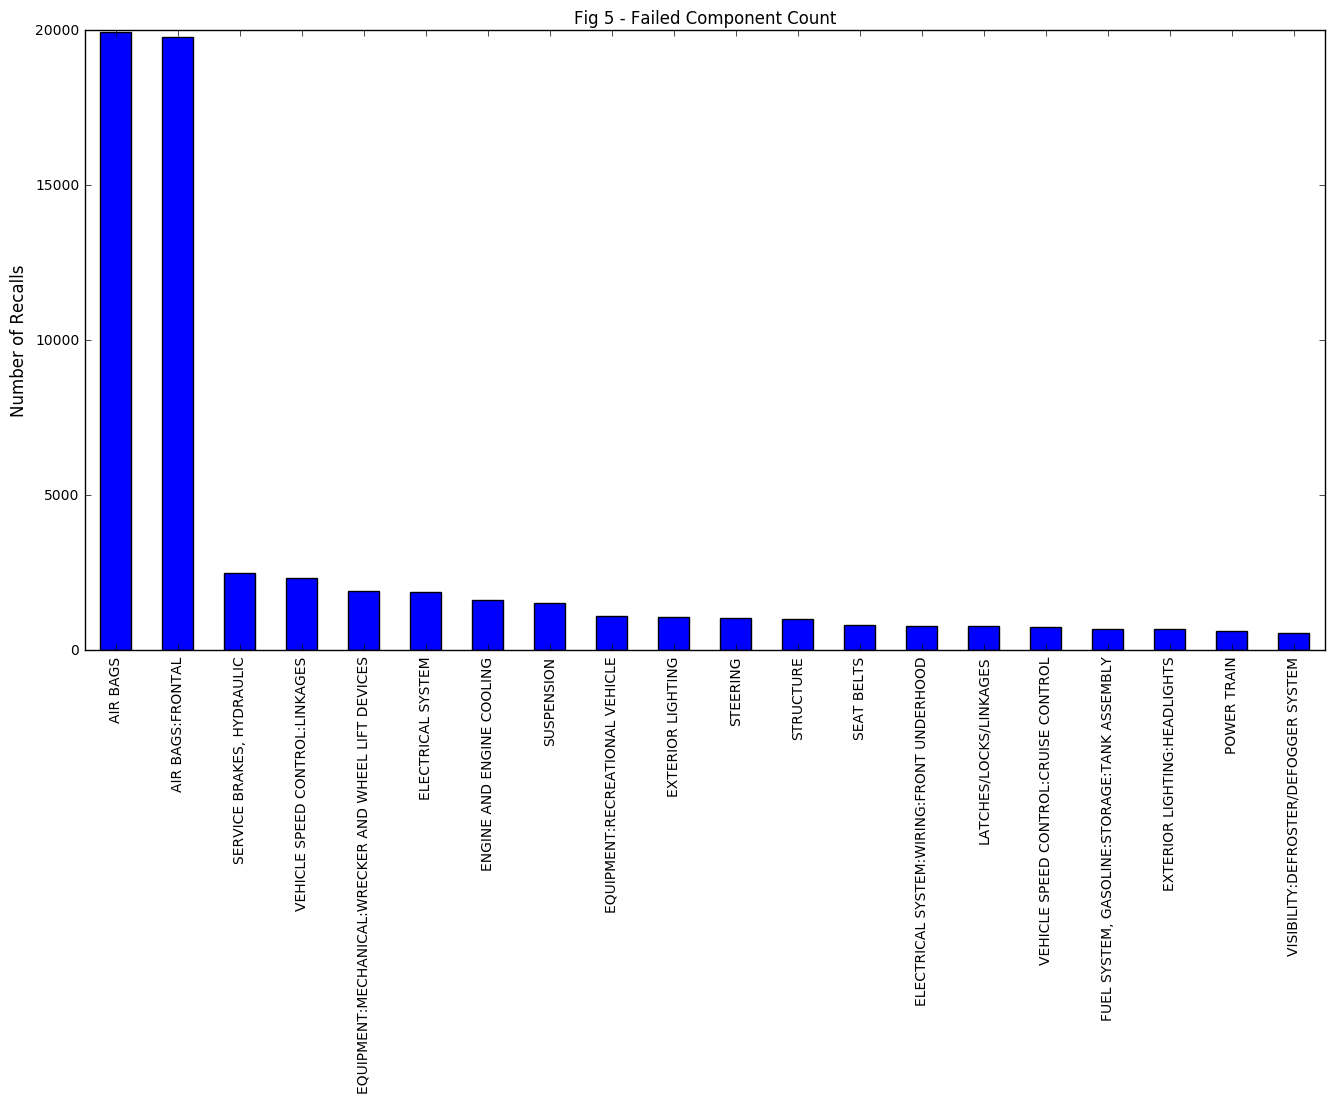

In [87]:
plt.figure(figsize=(16,8))
inv_df['COMPNAME'].value_counts().nlargest(20).plot(kind='bar')
plt.title("Fig 5 - Failed Component Count")
plt.ylabel('Number of Recalls', fontsize=12)
plt.gcf()

/Users/matt/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


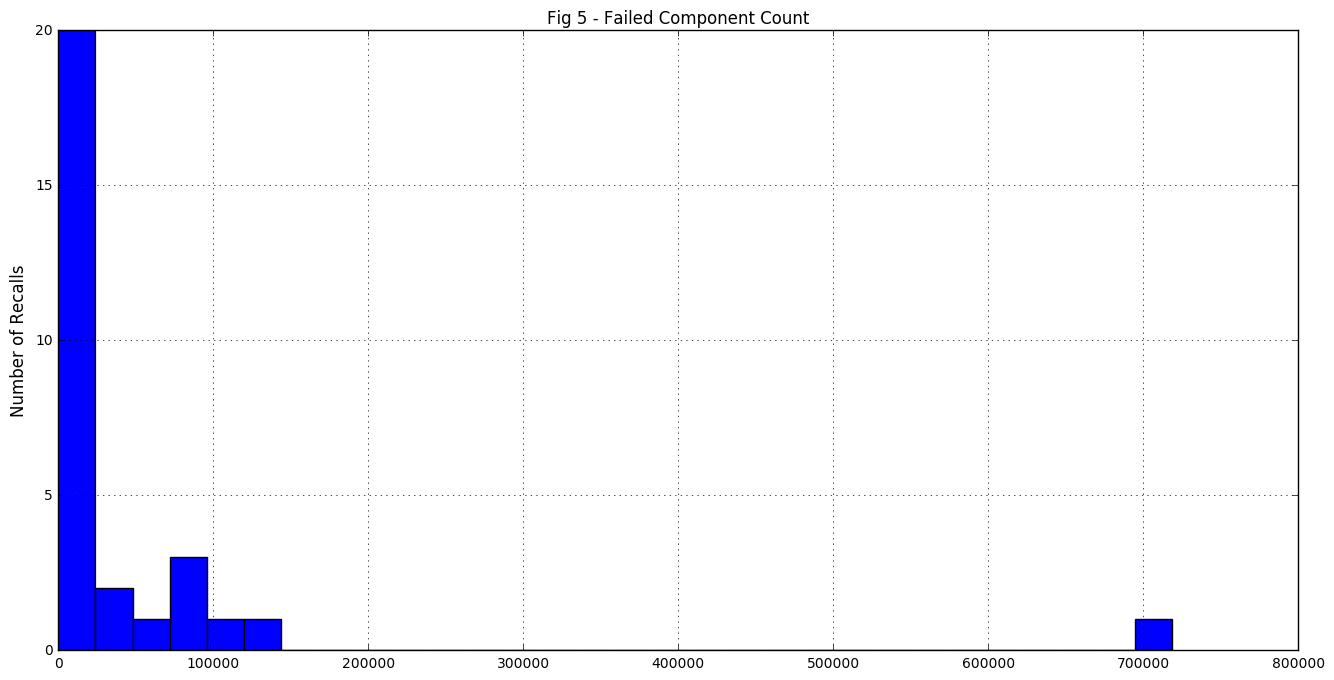

In [132]:
plt.figure(figsize=(16,8))
numBins = 30
bins = py.linspace(0, 500000, numBins)

cmpl_df['MILES'] = cmpl_df['MILES'].fillna(cmpl_df['MILES'].mean())
cmpl_df['MILES']

bin_df = pd.cut(cmpl_df['MILES'],bins)
bin_df.value_counts().hist(bins=numBins)
plt.title("Fig 5 - Failed Component Count")
plt.ylabel('Number of Recalls', fontsize=12)
plt.gcf()

In [115]:

cmpl_df = load_data_file('cmpl', 'latin1');

cmpl_df

C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (15,22,26,32,33,34,35,36,38,39,40,41,42,43,44,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,CMPLID,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,...,RESTRAINT_TYPE,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
0,1,958170.0,Ford Motor Company,MERCURY,COUGAR,1995.0,NaN,19950101.0,N,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
1,2,958146.0,General Motors LLC,GMC,SONOMA,1995.0,NaN,19941215.0,N,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
2,3,958149.0,"Nissan North America, Inc.",NISSAN,MAXIMA,1987.0,NaN,19941223.0,N,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
3,4,958127.0,Ford Motor Company,FORD,RANGER,1994.0,NaN,NaN,N,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
4,5,958146.0,General Motors LLC,GMC,SONOMA,1995.0,NaN,19941215.0,N,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
5,6,958189.0,MAZDA MOTOR CORP,MAZDA,626,1991.0,Y,19941203.0,N,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
6,7,958173.0,Ford Motor Company,LINCOLN,TOWN CAR,1994.0,Y,19941222.0,N,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
7,8,958146.0,General Motors LLC,GMC,SONOMA,1995.0,NaN,19941215.0,N,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
8,9,958161.0,GERRY,GERRY,CHILD SAFETY SEAT,1993.0,NaN,19941231.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,NaN
9,10,958117.0,FORD MOTOR COMPANY,FORD,PROBE,1991.0,NaN,19950103.0,N,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN


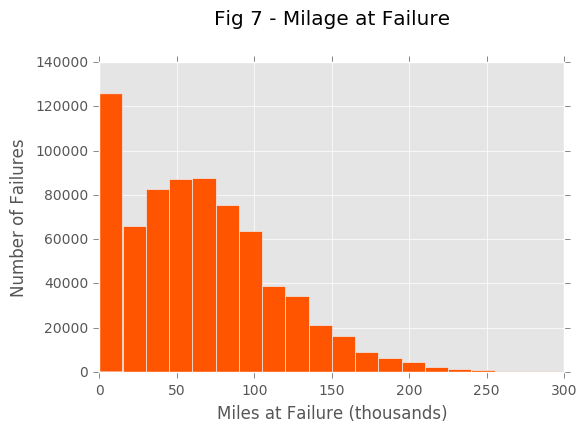

In [254]:
import numpy as py
import matplotlib
import matplotlib.pyplot as plt


#plt.figure()
#cmpl_df['MILES'].plot(kind='box')
#plt.gcf()
#cmpl_df['MILES'].describe()

col_miles = cmpl_df['MILES'].dropna();


#cmpl_df[(cmpl_df['MILES'] >= 99) & (cmpl_df['MILES'] <= 101)]["MILES"]
#cmpl_df[(cmpl_df['MILES'] < 0)]["MILES"]

clean_miles = cmpl_df[(cmpl_df["MILES"] >= 0) & (cmpl_df["MILES"] < 300000)]["MILES"]

clean_miles = clean_miles / 1000;

clean_df = cmpl_df[(cmpl_df["MILES"] >= 0) & (cmpl_df["MILES"] < 300000)]

plt.figure()
clean_miles.hist(bins=20, color='#FF5500')
#clean_df.plot(kind='scatter', x='MILES', y='OCCURENCES');
plt.title("Fig 7 - Milage at Failure", y=1.1)
plt.ylabel('Number of Failures', fontsize=12)
plt.xlabel('Miles at Failure (thousands)', fontsize=12)
plt.gcf()



C:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


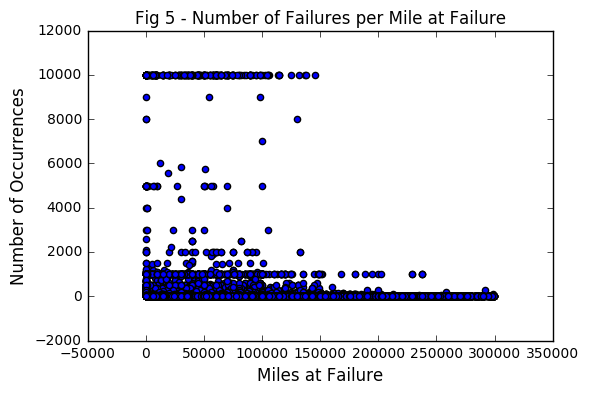

In [36]:

clean_df = cmpl_df[(cmpl_df["MILES"] >= 0) & (cmpl_df["MILES"] < 300000)]

plt.figure()
clean_df.plot(kind='scatter', x='MILES', y='OCCURENCES');
plt.title("Fig 5 - Number of Failures per Mile at Failure")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Miles at Failure', fontsize=12)
plt.gcf()

#create_box_graph(clean_df, col_x='MILES', col_y='OCCURENCES', num_bins=10);



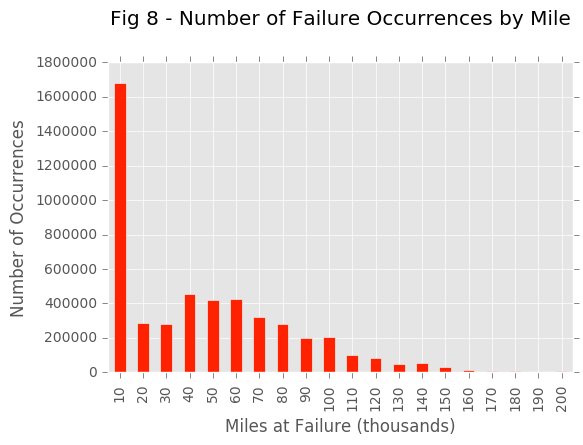

In [255]:
import math;
matplotlib.style.use('ggplot')

curr_df = cmpl_df[["MILES", "OCCURENCES"]].dropna();
#curr_df = [(curr_df["MILES"] >= 980000) & (curr_df["MILES"] < 1000000)]

numBins = 20 + 1;
bins = py.linspace(0, 200000, numBins);
#bins = py.linspace(0, 50000, numBins);
#bin_df = pd.cut(curr_df['MILES'], bins, labels=bins[1:])

#print(bin_df)

binLabels = bins[1:];
binLabels = list(map(lambda x: math.floor(x / 1000), binLabels));
    
    
plt.figure()
curr_df.groupby(pd.cut(curr_df["MILES"], bins, labels=binLabels))["OCCURENCES"].sum().plot(kind='bar', color='#FF2200')
#bin_df.value_counts(sort=False).plot(kind='bar')
plt.title("Fig 8 - Number of Failure Occurrences by Mile", y=1.1);
plt.xlabel("Miles at Failure (thousands)", fontsize=12);
plt.ylabel("Number of Occurrences", fontsize=12);
plt.gcf()

#bins = py.linspace(0, 300000, numBins)
#bins = math.floor(bins)
#bins
#bin_df.value_counts(sort=False)

#cmpl_df['MILES'].value_counts()
#bin_df.describe()
#cmpl_df["MILES"].describe()

#bins = [900000, 1000000];
#cmpl_df.groupby(pd.cut(cmpl_df['MILES'], bins))["OCCURENCES"].describe()

#curr_df["OCCURENCES"].describe()
#curr_df[(curr_df["OCCURRENCES"] >= 980000) & (curr_df["MILES"] < 1000000)]

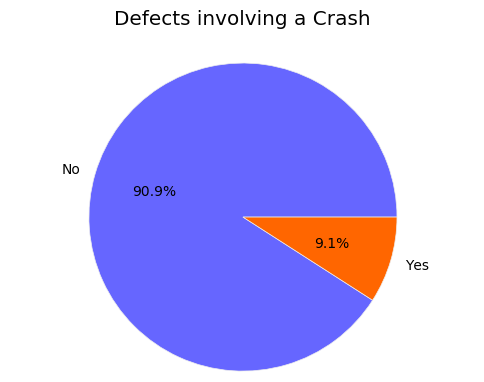

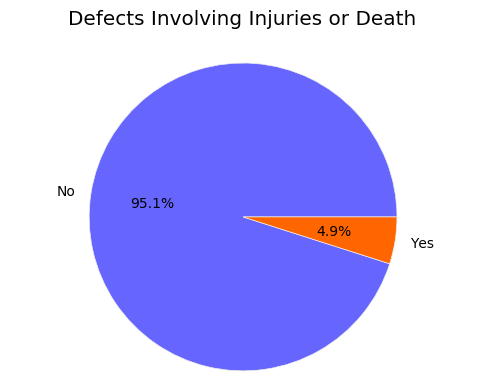

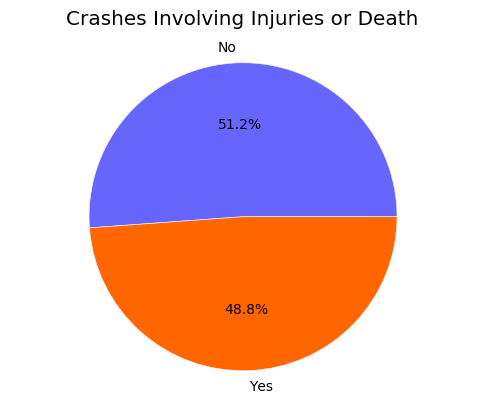

In [252]:

matplotlib.style.use('ggplot')

orange = '#FF6600';
blue = '#6666FF';

plotParams = {'labels':['No','Yes'], 'colors':[blue, orange], 'autopct':'%1.1f%%'}
titleOffset = 1.1;

plt.figure()
#cmpl_df["CRASH"].value_counts().plot.pie(labels=['No','Yes'], colors=[blue, orange], autopct='%1.1f%%');
cmpl_df["CRASH"].value_counts().plot.pie(**plotParams);
plt.title("Defects involving a Crash", y=titleOffset);
plt.axis('equal')
plt.ylabel("");
plt.show();

plt.figure()
((cmpl_df["INJURED"] > 0) | (cmpl_df["DEATHS"] > 0)).value_counts().plot.pie(**plotParams);
plt.title("Defects Involving Injuries or Death", y=titleOffset);
plt.axis('equal')
plt.ylabel("");
plt.show();

crashes_df = cmpl_df[cmpl_df["CRASH"] == 'Y'];

plt.figure()
#((cmpl_df["INJURED"] > 0) | (cmpl_df["DEATHS"] > 0)).value_counts().plot.pie();
((crashes_df["INJURED"] > 0) | (crashes_df["DEATHS"] > 0)).value_counts().plot.pie(**plotParams);
plt.title("Crashes Involving Injuries or Death", y=titleOffset);
plt.axis('equal')
plt.ylabel("");
plt.show();

